In [123]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [115]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + -1*other
    
    def __rsub__(self, other):
        return self - other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [116]:
from graphviz import Digraph

def trace(root):
    
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [117]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label = "x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh()

e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = "o"
o.backward()



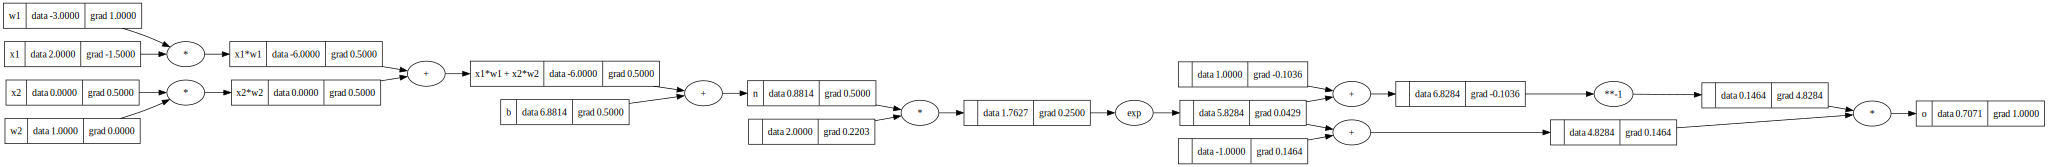

In [118]:
draw_dot(o)

In [109]:
Value(5) + 1

Value(data=6)

In [158]:

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [257]:
x = [2.0, 3.0, -1]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.5834455219797778)

In [260]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [276]:
for k in range(1000):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass, remember to zero the gradient
    for p in n.parameters():
        p.grad = 0.0
        
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 9.950341509614256e-05
1 9.940628463845722e-05
2 9.93093108888788e-05
3 9.921249349997893e-05
4 9.911583212532054e-05
5 9.901932641945158e-05
6 9.892297603791003e-05
7 9.882678063720901e-05
8 9.873073987484048e-05
9 9.86348534092745e-05
10 9.853912089994247e-05
11 9.84435420072519e-05
12 9.834811639256957e-05
13 9.825284371822458e-05
14 9.815772364749778e-05
15 9.806275584463028e-05
16 9.796793997480817e-05
17 9.787327570416961e-05
18 9.777876269978683e-05
19 9.768440062968558e-05
20 9.759018916281835e-05
21 9.74961279690746e-05
22 9.740221671927435e-05
23 9.730845508516436e-05
24 9.721484273941658e-05
25 9.71213793556204e-05
26 9.702806460828573e-05
27 9.693489817283684e-05
28 9.684187972560771e-05
29 9.67490089438415e-05
30 9.665628550568579e-05
31 9.656370909018954e-05
32 9.647127937730023e-05
33 9.637899604786079e-05
34 9.628685878360836e-05
35 9.619486726716624e-05
36 9.610302118204474e-05
37 9.601132021264215e-05
38 9.591976404422912e-05
39 9.582835236295916e-05
40 9.57370848558

351 7.304865615836825e-05
352 7.299059385942677e-05
353 7.293260903536633e-05
354 7.287470154508963e-05
355 7.28168712478214e-05
356 7.275911800311712e-05
357 7.270144167085502e-05
358 7.26438421112352e-05
359 7.258631918478823e-05
360 7.2528872752356e-05
361 7.247150267511082e-05
362 7.241420881454123e-05
363 7.235699103245374e-05
364 7.229984919097834e-05
365 7.224278315255705e-05
366 7.218579277995429e-05
367 7.212887793624486e-05
368 7.207203848482122e-05
369 7.201527428938936e-05
370 7.19585852139676e-05
371 7.190197112288967e-05
372 7.184543188079828e-05
373 7.17889673526462e-05
374 7.173257740369884e-05
375 7.167626189952477e-05
376 7.162002070600346e-05
377 7.1563853689326e-05
378 7.150776071598378e-05
379 7.14517416527734e-05
380 7.139579636679857e-05
381 7.13399247254688e-05
382 7.128412659648951e-05
383 7.122840184787402e-05
384 7.117275034793399e-05
385 7.111717196528437e-05
386 7.10616665688345e-05
387 7.100623402779475e-05
388 7.095087421167658e-05
389 7.089558699028258e-

738 5.525966891300165e-05
739 5.5223506238227536e-05
740 5.518738416424836e-05
741 5.515130262883209e-05
742 5.5115261569867305e-05
743 5.50792609253651e-05
744 5.504330063345177e-05
745 5.500738063237564e-05
746 5.4971500860507155e-05
747 5.493566125633079e-05
748 5.48998617584511e-05
749 5.486410230559418e-05
750 5.48283828366027e-05
751 5.4792703290433296e-05
752 5.475706360616869e-05
753 5.4721463722999494e-05
754 5.468590358024056e-05
755 5.465038311731837e-05
756 5.461490227378126e-05
757 5.4579460989291465e-05
758 5.454405920362292e-05
759 5.450869685667341e-05
760 5.4473373888449e-05
761 5.44380902390752e-05
762 5.440284584879208e-05
763 5.4367640657952134e-05
764 5.4332474607023706e-05
765 5.429734763659026e-05
766 5.426225968734716e-05
767 5.422721070010514e-05
768 5.419220061578539e-05
769 5.415722937542576e-05
770 5.4122296920175256e-05
771 5.408740319129605e-05
772 5.405254813016019e-05
773 5.4017731678255616e-05
774 5.398295377717989e-05
775 5.394821436863987e-05
776 5.39